In [1]:
import argparse
import json
import logging
import math
import os
import random
from dataclasses import dataclass
from itertools import chain
from pathlib import Path
from typing import Optional, Union

import datasets
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import evaluate
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from huggingface_hub import Repository
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    AutoModelForMultipleChoice,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    SchedulerType,
    default_data_collator,
    get_scheduler,
)
from transformers.utils import PaddingStrategy, check_min_version, get_full_repo_name, send_example_telemetry

from utils import init_trad_from_simplified

In [3]:
# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
#check_min_version("4.24.0.dev0")

logger = get_logger(__name__)
# You should update this to your particular problem to have better documentation of `model_type`
MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [13]:
MODEL_MAPPING.keys()[0], MODEL_MAPPING.values()[0], MODEL_TYPES[0]

(transformers.models.albert.configuration_albert.AlbertConfig,
 transformers.models.albert.modeling_albert.AlbertModel,
 'albert')

# Q2

In [3]:
config = AutoConfig.from_pretrained("hfl/chinese-bert-wwm-ext")

In [4]:
print(config)

BertConfig {
  "_name_or_path": "hfl/chinese-bert-wwm-ext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}



# Q3: Curves

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ROOT = "./work"

In [ ]:
def read_em_n_loss(path="qa1"):
    path = os.path.join(
        path, "intermediate.txt"
    )
    file_name = os.path.join(
        ROOT, path
    )
    steps, losses, ems = [], [], []
    with open(file_name) as file:
        for line in file:
            tmp = line.split(" ")
            step = tmp[2]
            em = float(tmp[5][:-1])
            loss = float(tmp[9])
            steps.append(step), losses.append(loss), ems.append(em)
            
    return_dict = {
        'steps': steps,
        'losses': losses,
        'ems': ems
    }
    return return_dict

In [ ]:
deberta_dict = read_em_n_loss("qa1")
roberta_dict = read_em_n_loss("qa2")
macbert_dict = read_em_n_loss("qa3")

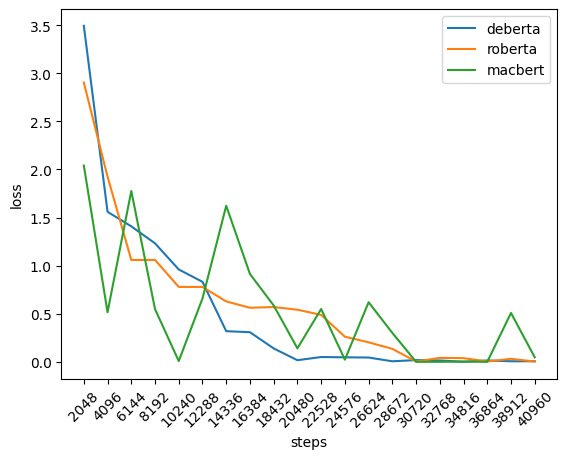

In [ ]:
plt.plot(deberta_dict["steps"], deberta_dict["losses"], label='deberta')
plt.plot(roberta_dict["steps"], roberta_dict["losses"], label='roberta')
plt.plot(macbert_dict["steps"], macbert_dict["losses"], label='macbert')
plt.legend()
plt.xlabel('steps')
plt.xticks(rotation=45)
plt.ylabel('loss')
plt.savefig("./report/loss_plot.png")
plt.show()

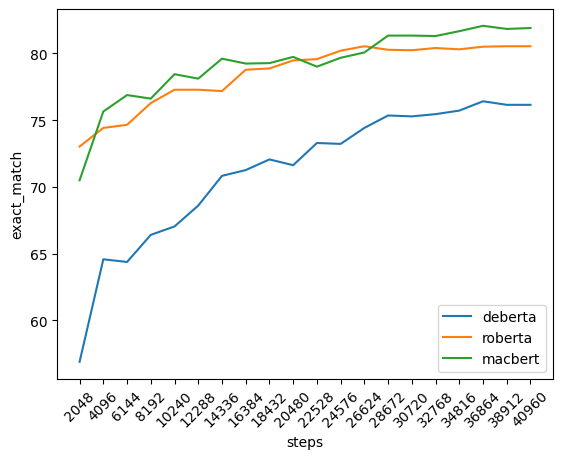

In [10]:
plt.plot(deberta_dict["steps"], deberta_dict["ems"], label='deberta')
plt.plot(roberta_dict["steps"], roberta_dict["ems"], label='roberta')
plt.plot(macbert_dict["steps"], macbert_dict["ems"], label='macbert')
plt.legend()
plt.xlabel('steps')
plt.xticks(rotation=45)
plt.ylabel('exact_match')
plt.savefig("./report/em_plot.png")
plt.show()

# Q4

In [4]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice, AutoConfig

# Note: Loading a model from its configuration file does not load the model weights. 
# It only affects the model’s configuration. 
# Use from_pretrained() to load the model weights.

tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
config = AutoConfig.from_pretrained("bert-base-chinese")
model = AutoModelForMultipleChoice.from_config(config)

In [7]:
print(config)

BertConfig {
  "_name_or_path": "bert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}



In [5]:
print(model)

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff